# Models Training and Evaluation - Railway


## Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import csv
import re
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import itertools

[nltk_data] Downloading package punkt to /home/riccardo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Importing the dataset
file_path = os.path.join("..", "input", "dataset_eng_cleaned.csv")

df = pd.read_csv(file_path, index_col = 0, names=["text", "label"])

# Defining a function to perform data cleaning
def clean_text(text):
    # 1) Removing punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # 2) Getting rid of numbers
    text = re.sub(r'\d+', '', text)
    # 3) Removing words which have 2 or less letters
    text = ' '.join([word for word in text.split() if len(word) > 2])
    # 4) Making text lowercase
    return text.lower()

# Applying the function to the text column
df["text"] = df["text"].apply(clean_text)

In [3]:
df.head()

,text,label
UsNB_SOM2_DOC1_0012,technological refresh the som which involveso ...,1
UsNB_SOM2_DOC1_0013,creation second server room the san donato sit...,1
UsNB_SOM2_DOC1_0014,creation second operations room disaster recov...,1
UsNB_SOM2_DOC1_0015,porting the alstom software onto the new alsto...,1
UsNB_SOM2_DOC1_0016,moving replacing software telex rich client,1


In [4]:
requirement_words = [
    'must', 'shall', 'should', 'need', 'require', 'necessary',
    'obligated', 'mandatory', 'compulsory', 'demanded', 'essential',
    'prerequisite', 'prerequisites', 'precondition', 'condition', 'necessary', 'needful',
    'requisite', 'requisites', 'needed', 'expected', 'necessary', 'demand', 'expectation',
    'require', 'specification', 'guideline', 'instruction', 'necessity',
    'stipulation', 'condition', 'request', 'necessitate', 'requirement',
    'requirements'
]

In [5]:
import numpy as np

def assign_custom_label(X_test, y_pred, requirement_words):
    for i in range(X_test.shape[0]): 
        if not isinstance(X_test[i], np.ndarray):
            words_in_sentence = set(np.flatnonzero(X_test[i].toarray()))  
        else:
            words_in_sentence = set(np.flatnonzero(X_test[i]))
        for word in requirement_words:
            if word in words_in_sentence:
                y_pred[i] = 1
                break
    return y_pred

## Bag of Words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

X = df["text"]
y = df["label"]
vectorizer = CountVectorizer(stop_words='english')
X_cv = vectorizer.fit_transform(X)

# Creating custom binary features for positive indicator words
custom_features = np.zeros((X_cv.shape[0], len(requirement_words)))

for i, text in enumerate(X_cv):
    for j, word in enumerate(requirement_words):
        if word in df["text"]:
            custom_features[i, j] = 1

# Combining the bag-of-words features with the custom features
X_combined = np.hstack((X_cv.toarray(), custom_features))


# Split the data into training validatoon and test sets (70-15-15)

X_train, _texts, y_train, _labels = train_test_split(X_combined, y,
                                                    random_state=42, test_size=0.3)
X_test, _, y_test, _ = train_test_split(_texts, _labels,
                                                    random_state=42, test_size=0.5)

In [7]:
# Computing the class weights
total_samples = len(y_train)
class_0_samples = (y_train == 0).sum()
class_1_samples = (y_train == 1).sum()

weight_for_class_0 = total_samples / (2 * class_0_samples)
weight_for_class_1 = total_samples / (2 * class_1_samples)

class_weights = {0: weight_for_class_0, 1: weight_for_class_1}

### Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model_lr = LogisticRegression(class_weight = class_weights, solver='sag',\
                              max_iter=1000)

# training the model
model_lr.fit(X_train, y_train)

# making predictions on the test data
y_pred_lr = assign_custom_label(X_test, model_lr.predict(X_test), requirement_words)

# model evaluation
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.59      0.76      0.66       563
           1       0.88      0.76      0.82      1268

    accuracy                           0.76      1831
   macro avg       0.73      0.76      0.74      1831
weighted avg       0.79      0.76      0.77      1831



/home/riccardo/miniconda3/envs/alstom/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


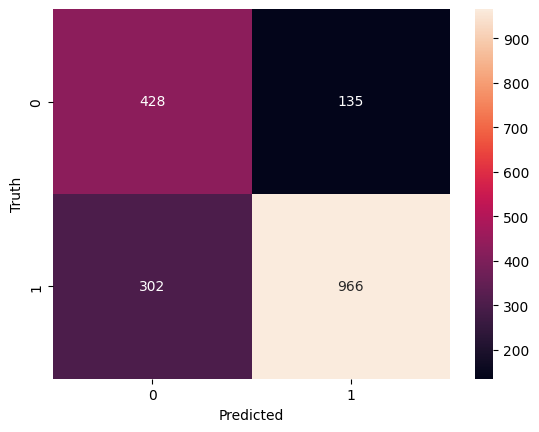

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# creating a heatmap
plt.figure()
label_names = list(model_lr.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_names, yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [10]:
# Geting the coefficients from the trained linear model
coefficients = model_lr.coef_[0]

# Geting the list of words (features) from the CountVectorizer
words = vectorizer.get_feature_names_out()

# Creating a list of (word, coefficient) pairs and sort them based on the absolute coefficient values
word_coefficient_pairs = list(zip(words, coefficients))
word_coefficient_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

# Printing the top 30 most important words
print("Top 30 Most Important Words:")
for word, coefficient in word_coefficient_pairs[:30]:
    print(f"{word}: {coefficient}")

Top 30 Most Important Words:
means: -2.0542589240033613
ertmsetcs: -1.9997668603155974
lan: -1.9917631600570889
equipments: 1.9384632649777351
vii: 1.8259645421428663
iii: 1.8203957536805908
layout: 1.7751804716383428
possession: -1.7211768211967766
defines: -1.715009234127078
utilities: -1.7017709517549653
identify: 1.6781036943661922
sqm: 1.6710448300465572
gpp: 1.6305865072817347
note: -1.6059426104703396
visual: 1.6014870996009967
guidelines: -1.5919669417437594
basis: -1.5683047567984976
develop: 1.5616879728627908
packet: 1.52843796170913
indications: -1.5006916730609237
all_: 1.4930931621255614
indication: 1.4721815603007848
arrangement: 1.4669031698127082
days: 1.4654242243546343
tested: 1.4601753950906755
rfi: -1.4515131996462265
general: -1.4514804039844504
pis: 1.4485294656653471
width: 1.4390346298143388
emi: 1.4341324794447476


### SVM

In [11]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

svm_model = LinearSVC(class_weight = class_weights)

svm_model.fit(X_train, y_train)

# Making predictions on the test data
y_pred_svm = assign_custom_label(X_test, svm_model.predict(X_test), requirement_words)

# Model evaluation
print("Support Vector Machine (SVM) Results:")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine (SVM) Results:
              precision    recall  f1-score   support

           0       0.59      0.72      0.65       563
           1       0.86      0.78      0.82      1268

    accuracy                           0.76      1831
   macro avg       0.73      0.75      0.73      1831
weighted avg       0.78      0.76      0.77      1831



/home/riccardo/miniconda3/envs/alstom/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


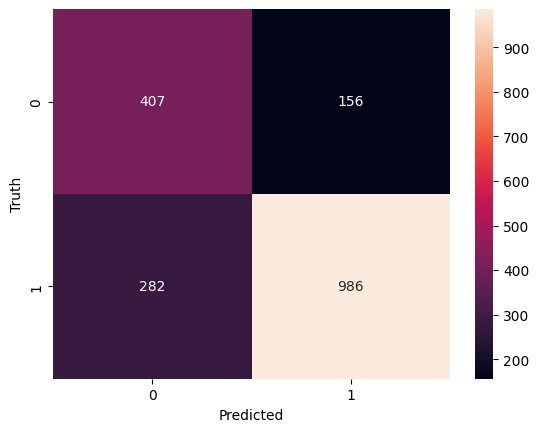

In [12]:
# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# creating a heatmap
plt.figure()
label_names = list(svm_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_names, yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [13]:
# Geting the coefficients from the trained linear model
coefficients = svm_model.coef_[0]

# Geting the list of words (features) from the CountVectorizer
words = vectorizer.get_feature_names_out()

# Creating a list of (word, coefficient) pairs and sort them based on the absolute coefficient values
word_coefficient_pairs = list(zip(words, coefficients))
word_coefficient_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

# Printing the top 30 most important words
print("Top 30 Most Important Words:")
for word, coefficient in word_coefficient_pairs[:30]:
    print(f"{word}: {coefficient}")

Top 30 Most Important Words:
fuel: -2.196665591748467
possession: -1.9731234456951854
describes: -1.7935169292124955
satisfying: -1.731117690611696
congestion: 1.69239024550556
implementing: -1.6814382834393857
occlocal: -1.6329255565625622
equipmentproduct: -1.5691991279143198
appendixn: -1.5685111233747193
basis: -1.543340648038907
optic: 1.5332333631603012
vii: 1.5274966204156775
approx: -1.5077531717128128
means: -1.507624060380517
guidelines: -1.4851238835074962
days: 1.4751551929193154
identifies: 1.4554345304222898
identify: 1.4518831278086564
systematic: -1.4307578488010415
cross: 1.4294802432103872
switches: 1.4230090199776968
ues: 1.4173309237975733
develop: 1.4127514145576874
impact: 1.3968247099716407
fall: 1.389523324462977
milestones: 1.38877392622683
lan: -1.3847653358010295
gpp: 1.375117333772448
demarcation: 1.371145961378891
seek: -1.3615245980624395


### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Creating and train the Random Forest classifier
rf_model = RandomForestClassifier(class_weight = class_weights, \
                                  n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions on the test data
y_pred_rf = assign_custom_label(X_test, rf_model.predict(X_test), requirement_words)

# Model evaluation
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       563
           1       0.84      0.87      0.86      1268

    accuracy                           0.80      1831
   macro avg       0.77      0.75      0.76      1831
weighted avg       0.80      0.80      0.80      1831



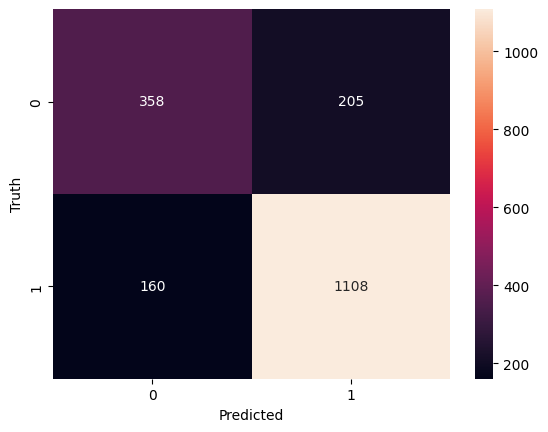

In [15]:
# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# creating a heatmap
plt.figure()
label_names = list(rf_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_names, yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [16]:
# Geting the feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Geting the list of words (features) from the CountVectorizer
words = vectorizer.get_feature_names_out()

# Creating a list of (word, importance) pairs and sort them based on the importance values
word_importance_pairs = list(zip(words, feature_importances))
word_importance_pairs.sort(key=lambda x: x[1], reverse=True)

# Printing the top 30 most important words
print("Top 30 Most Important Words:")
for word, importance in word_importance_pairs[:30]:
    print(f"{word}: {importance}")

Top 30 Most Important Words:
shall: 0.05679498323720277
contractor: 0.009120273391951062
train: 0.006680651995991883
provide: 0.006186937191373501
general: 0.0057515046575623285
equipment: 0.005146511247690706
including: 0.005005796010591903
following: 0.004983797770718136
ertmsetcs: 0.004907634220450651
test: 0.004591266157594303
required: 0.004224270394536648
design: 0.004116066641699868
point: 0.0036378527627688832
support: 0.003567657373348203
tests: 0.0034546829150301998
iii: 0.0033675952416917054
requirements: 0.003213687918591793
used: 0.003141208024208399
management: 0.003129278044976706
time: 0.0030974269431719727
employers: 0.0030664055896172365
control: 0.0028829886215726245
signal: 0.002866979649533763
number: 0.0027680066178682127
minimum: 0.002742213761268984
submit: 0.002729044316422218
include: 0.002620898085899146
information: 0.002592437385717582
door: 0.002544791834857432
station: 0.0025299405936838036


### Multinomial Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Calculating sample weights based on class distribution
sample_weights = np.where(y_train == 0, weight_for_class_0, weight_for_class_1)

# Creating and training the Naive Bayes classifier with sample weights
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Making predictions on the test data
y_pred_nb = assign_custom_label(X_test, nb_model.predict(X_test), requirement_words)

# Model evaluation
print("Multinomial Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))

Multinomial Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       563
           1       0.82      0.85      0.84      1268

    accuracy                           0.77      1831
   macro avg       0.73      0.72      0.72      1831
weighted avg       0.76      0.77      0.77      1831



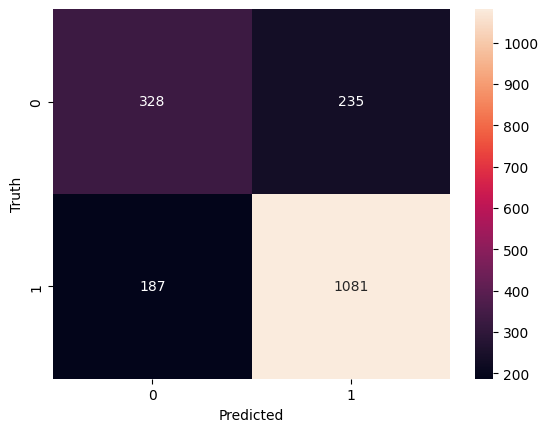

In [18]:
# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)

# creating a heatmap
plt.figure()
label_names = list(nb_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_names, yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Metamodel: voting classifier

In [20]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('logistic_regression', model_lr),
        ('support_vector_machines', svm_model),
        ('random_forest', rf_model),
        ('multinomial_naive_bayes', nb_model),
    ],
    voting='hard' 
)

voting_clf.fit(X_train, y_train)

/home/riccardo/miniconda3/envs/alstom/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/riccardo/miniconda3/envs/alstom/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(class_weight={0: 1.6834844304296412,
                                                               1: 0.711240632805995},
                                                 max_iter=1000, solver='sag')),
                             ('support_vector_machines',
                              LinearSVC(class_weight={0: 1.6834844304296412,
                                                      1: 0.711240632805995})),
                             ('random_forest',
                              RandomForestClassifier(class_weight={0: 1.6834844304296412,
                                                                   1: 0.711240632805995},
                                                     random_state=42)),
                             ('multinomial_naive_bayes', MultinomialNB())])

In [21]:
# making predictions on the test data
y_pred_voting = assign_custom_label(X_test, voting_clf.predict(X_test), requirement_words)

# model evaluation
print(classification_report(y_test, y_pred_voting))

              precision    recall  f1-score   support

           0       0.61      0.75      0.67       563
           1       0.88      0.78      0.83      1268

    accuracy                           0.77      1831
   macro avg       0.74      0.77      0.75      1831
weighted avg       0.79      0.77      0.78      1831



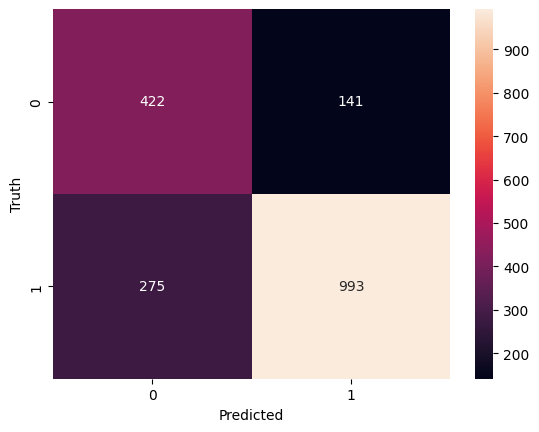

In [22]:
# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_voting)

# creating a heatmap
plt.figure()
label_names = list(voting_clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_names, yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Saving the Metamodel

In [23]:
from joblib import dump, load
dump(voting_clf, 'metamodel.pkl')
# use metamodel = joblib.load('metamodel.pkl') to reuse the trained model

['metamodel.pkl']